# Computational Psycholinguistics - Assignment 2
By Daan Brugmans

This assignment is an investigation in to the ability for Recurrent Neural Networks to predict the P600 ERP Component.
The P600 Component is a peak in brain activity that is measured using EEG and is thought to relate to the human language system, specifically in the processing of syntax errors.
Recent work by [Fitz & Chang (2019)](https://www.sciencedirect.com/science/article/pii/S0010028518300124) and [Frank (2024)](osf.io/preprints/psyarxiv/cx3h6) propose that the P600 Component may be the backpropagation of language error in the brain.
Since Recurrent Neural Networks trained on language data also backpropagate their prediction errors using gradients, there may exist similarities between the language error backpropagation of human and artificial neural language systems.
This notebook is an investigation into these potential similarities.
We will investigate the relation between the gradients and surprisal values of trained RNNs of increasing size and measured P600 components from a controlled experiment.

## Imports
We import required libraries and code provided by the lecturer of the course in `get_predictions.py`.

In [217]:
from get_predictions import get_predictions

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.io
import torch

## Setup
We set a global seed to improve reproducibility of our results.
We also set some constants required for the lecturer's code to work.

In [218]:
def set_global_seed(seed):
    """Sets the same seed for varying libraries."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

RAW_DATA_FILE_PATH = "./data/stimuli_erp.mat"
EXPERIMENTAL_STIMULI_FILE_PATH = "./items/stimuli.txt"

ITEM_SETS = ["stimuli"]
LANGUAGE = "en"
CUDA = True

set_global_seed(3131)

## Loading the Raw Data
We load the data from the controlled experiment.
This is a .mat file and contains both the sentences read by the participants of the experiment, and the recorded values for six ERP Components measured during the experiment.

In [219]:
dataset = scipy.io.loadmat(RAW_DATA_FILE_PATH)
sentences = dataset["sentences"]
erp_data = dataset["ERP"]

# Shape of the ERP data
print(erp_data.shape) # NOTE: All ERP averages
print(erp_data[0].shape) # NOTE: All ERP averages for sentence 0 as one single tuple
print(erp_data[0][0].shape) # NOTE: All ERP averages for sentence 0 as a tuple of (words, participants, ERP components)
print(erp_data[0][0][0].shape) # NOTE: All ERP averages for word 0 of sentence 0
print(erp_data[0][0][0][0].shape) # NOTE: All ERP averages for participant 0 for word 0 of sentence 0
print(erp_data[0][0][0][0][4]) # NOTE: P600 ERP average for participant 0 for word 0 of sentence 0

(205, 1)
(1,)
(5, 24, 6)
(24, 6)
(6,)
-1.8152039051055908


## Generating the Plain Text Stimuli File
The code provided by the lecturer automatically calculated surprisal and gradients of the RNNs on a text file of sentences.
We use the sentence data from the controlled experiment to automatically generate a plain text file that fulfills the requirements set by the lecturer's code.
This generated file can be found in `./items/stimuli.txt`.

In [220]:
with open(EXPERIMENTAL_STIMULI_FILE_PATH, "w") as stimuli_file:
    for sentence in sentences:
        # Get the tuple of every word in the sentence
        sentence = sentence[0][0]
        
        for index, word in enumerate(sentence):
            word = str(word[0])            
            word = word.lower()
            
            if "." in word:
                word = word.replace(".", " .")
                
            stimuli_file.write(word)
            
            if index == len(sentence) - 1:
                stimuli_file.write("\n")
            else:
                stimuli_file.write(" ")

## Parsing the P600 Data by Sentence
We parse the P600 data from the controlled experiment into the same format used by the lecturer's code.
This allows us to easily merge this data together with the surprisal and gradient data.

We store a P600 Component value for every word in every sentence.
However, since there are 24 participants of the study that we load the data from, we have 24 P600 values for every word.
I have decided to take the mean of the P600 components so that the results can be generalized to the entire population of the 24 participants.
I have intentionally chosen the mean over the median since its sensitivity to outliers causes the mean to include more information about participants with P600 values that were non-standard.

In [221]:
parsed_p600_data = []

# For every sentence read by participants in the study...
for sentence_index, erp_sentence_data in enumerate(erp_data):
    # Get a tuple of the sentence's (words, participants, ERP components)
    erp_sentence_data = erp_sentence_data[0]
    
    # For every word in the sentence...
    for word_index, erp_word_data in enumerate(erp_sentence_data):
        # Get the P600 component for that word for all participants, then get the mean
        p600s_for_word = erp_word_data[:, 4]
        mean_p600_for_word = np.nanmean(p600s_for_word)
        
        # Add a row to the parsed_p600_list in the same format as the .csvs generated by get_predictions
        parsed_p600_data.append([
            sentence_index + 1,
            word_index + 1,
            (100 * (sentence_index + 1)) + (word_index + 1),
            mean_p600_for_word
        ])
    
parsed_p600_data = pd.DataFrame(parsed_p600_data, columns=["sent_nr", "word_pos", "item", "erp_p600_mean"])
parsed_p600_data

,sent_nr,word_pos,item,erp_p600_mean
0,1,1,101,0.120309
1,1,2,102,0.267218
2,1,3,103,-1.320961
3,1,4,104,-1.997875
4,1,5,105,0.073727
...,...,...,...,...
1926,205,8,20508,-0.482811
1927,205,9,20509,-0.392591
1928,205,10,20510,-0.044603
1929,205,11,20511,-1.481856


## Generating the Model Surprisal Values
We generate the surprisal values of the various models on the sentence data from the study using `get_predictions.py`

In [222]:
get_predictions(ITEM_SETS, LANGUAGE, "surp", CUDA)

model_stimuli_surprisal_df = pd.read_csv("./predictions/surp_stimuli.csv", sep="\t")
del model_stimuli_surprisal_df["Unnamed: 0"]

model_stimuli_surprisal_df

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,surp_30000000,surp_epoch1
0,1,1,101,6.836413,4.707911,3.947554,4.094619,4.726980,5.756513,6.399938,7.089447,6.435467
1,1,2,102,9.288938,8.235802,8.197250,7.507866,5.409412,6.177730,5.586932,5.922409,5.222564
2,1,3,103,9.142862,8.210672,8.031253,7.789608,4.846162,4.301919,3.926872,3.228703,4.466794
3,1,4,104,4.742215,4.672691,4.514076,4.958948,2.137337,0.943905,0.821426,0.915931,0.708956
4,1,5,105,5.913204,5.588213,5.787216,5.792560,6.385126,5.818783,5.915521,6.207226,6.074735
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,205,9,20509,9.468374,8.539412,8.570766,8.404335,7.364338,4.989576,3.788672,3.112464,3.001311
2132,205,10,20510,9.983400,9.125396,8.786782,8.881791,8.340035,7.244709,5.905184,6.397970,7.190235
2133,205,11,20511,6.348531,6.507536,6.513234,6.639857,4.121954,2.635970,2.201653,2.113567,1.915407
2134,205,12,20512,7.062437,7.243497,7.173066,7.001952,9.152929,5.869561,5.553642,5.024977,3.113113


## Generating the Model Gradients
We generate the gradients of the various models on the sentence data from the study using `get_predictions.py`

In [223]:
get_predictions(ITEM_SETS, LANGUAGE, "grad", CUDA)

model_stimuli_gradient_df = pd.read_csv("./predictions/grad_stimuli.csv", sep="\t")
del model_stimuli_gradient_df["Unnamed: 0"]

model_stimuli_gradient_df

,sent_nr,word_pos,item,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1
0,1,1,101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,102,18.973602,29.303833,23.013428,50.111851,155.621353,356.073730,591.474792,950.615173,916.272278
2,1,3,103,48.192589,52.353775,47.574013,133.064423,447.145355,992.735474,1233.697754,1474.690552,1340.782104
3,1,4,104,152.071564,194.270233,217.592896,418.993561,1268.529053,1716.162598,2588.392090,2718.549805,2131.545166
4,1,5,105,155.604553,74.379417,101.549599,167.167297,966.557861,2630.439453,4642.015625,4349.675293,4239.321777
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,205,9,20509,162.758682,104.815720,118.573441,241.563873,1338.155518,3129.649902,3442.307373,4006.755371,4073.013672
2132,205,10,20510,201.055206,96.702126,119.630630,262.677063,2134.760742,3840.750000,4937.511230,6278.169922,5755.274414
2133,205,11,20511,165.124695,93.393753,238.789093,248.142410,2945.145996,3598.960449,3727.153564,2389.245605,2220.633057
2134,205,12,20512,175.054016,91.080688,179.269196,357.131104,2670.154053,2342.652588,3812.427734,4139.393066,3849.694092


## Visualizing Correlations between Data
We define a function called `draw_lineplot`.
This function draws a scatterplot of the two provided vectors in addition to calculating and drawing a quadratic function fit to the data and the Pearson Correlation Coefficient (r) between the variables.

We merge the dataframes of the P600 Component data, model surprisal data, and model gradients data into one dataframe.
As is standard in the analysis of data regarding human reading, we remove the first and final words of every sentence from the data.
We also remove the model's data regarding the periods.

In [224]:
def draw_lineplot(x_axis_name: str, y_axis_name: str, df: pd.DataFrame, x_axis_label: str = None, y_axis_label: str = None, title: str = None) -> pd.DataFrame:   
    # Draw a linear regression plot, a scatter plot with a linear regression line on top of it
    plt.figure()
    plot = sns.lmplot(x=x_axis_name, y=y_axis_name, data=df, seed=3131, line_kws={"color": "C1"}, order=2)
    
    if (x_axis_label is not None) and (y_axis_label is not None):
        plot.set_axis_labels(x_axis_label, y_axis_label)
    
    if title is not None:
        plt.title(title)
    
    # Iterate over the data points in the plot
    for _, facet_df in plot.facet_data():
        # Remove missing values when calculating the linear regression
        facet_df = facet_df.dropna(axis=0)
        
        # Calculate slope, intercept, and correlation coefficient r of the linear regression shown in the plot
        _, _, r, _, _ = scipy.stats.linregress(
            x=facet_df[x_axis_name],
            y=facet_df[y_axis_name]
        )
                
        # Write the regression's formula onto the plot
        max_x = facet_df[x_axis_name].max(axis=0)
        max_y = facet_df[y_axis_name].max(axis=0)
        
        plt.text(max_x * 0.7, max_y * 0.95, f"r = {round(r, 3)}")
        
    return r


# Merging the model stimuli dataframes with each other and the ERP P600 dataframe
model_stimuli_df = pd.merge(model_stimuli_surprisal_df, model_stimuli_gradient_df.iloc[:, 2:], on="item")
model_stimuli_df = pd.merge(model_stimuli_df, parsed_p600_data.iloc[:, 2:], on="item") # NOTE: This merge removes rows about surprisal/gradients of periods

# Removing sentence-initial word and sentence-final word
model_stimuli_df = model_stimuli_df[~(model_stimuli_df["word_pos"].shift(-1) == 1)] # NOTE: Remove sentence-final words
model_stimuli_df = model_stimuli_df[~(model_stimuli_df["word_pos"] == 1)] # NOTE: Remove sentence-initial words
model_stimuli_df = model_stimuli_df.iloc[:-1, :] # NOTE: Remove the sentence-final word of the final sentence
model_stimuli_df

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,...,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1,erp_p600_mean
1,1,2,102,9.288938,8.235802,8.197250,7.507866,5.409412,6.177730,5.586932,...,18.973602,29.303833,23.013428,50.111851,155.621353,356.073730,591.474792,950.615173,916.272278,0.267218
2,1,3,103,9.142862,8.210672,8.031253,7.789608,4.846162,4.301919,3.926872,...,48.192589,52.353775,47.574013,133.064423,447.145355,992.735474,1233.697754,1474.690552,1340.782104,-1.320961
3,1,4,104,4.742215,4.672691,4.514076,4.958948,2.137337,0.943905,0.821426,...,152.071564,194.270233,217.592896,418.993561,1268.529053,1716.162598,2588.392090,2718.549805,2131.545166,-1.997875
6,2,2,202,10.343987,10.772951,10.055124,9.783902,9.598692,8.130068,7.441774,...,38.515953,44.912571,33.733639,37.512085,583.094421,1044.615845,1027.677734,1289.434814,1554.548340,-0.266926
7,2,3,203,3.655336,3.196918,3.985500,3.261256,2.296362,3.963031,3.440089,...,151.006027,55.935799,86.899811,289.253418,2119.205811,2901.414551,3102.004639,2600.237549,2634.064697,-0.328050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,205,7,20507,5.250892,5.221284,4.964741,4.788162,4.264303,4.479417,5.589550,...,172.044312,82.392807,109.042603,247.769608,2749.050293,3730.191406,3586.152344,3998.595215,3091.233643,-1.024113
1926,205,8,20508,6.366280,6.508044,6.487020,6.656782,4.828741,3.074005,2.855506,...,154.294449,87.633179,177.768814,216.795181,2340.139160,3971.171143,4107.865723,2959.993408,2628.775635,-0.482811
1927,205,9,20509,9.468374,8.539412,8.570766,8.404335,7.364338,4.989576,3.788672,...,162.758682,104.815720,118.573441,241.563873,1338.155518,3129.649902,3442.307373,4006.755371,4073.013672,-0.392591
1928,205,10,20510,9.983400,9.125396,8.786782,8.881791,8.340035,7.244709,5.905184,...,201.055206,96.702126,119.630630,262.677063,2134.760742,3840.750000,4937.511230,6278.169922,5755.274414,-0.044603


### Visualizing Correlations between Model Surprisal and Model Gradients
We draw plots of a model's surprisal values versus its gradient values for every model size, then draw a final plot to show the change in Pearson Correlation Coefficient between the variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

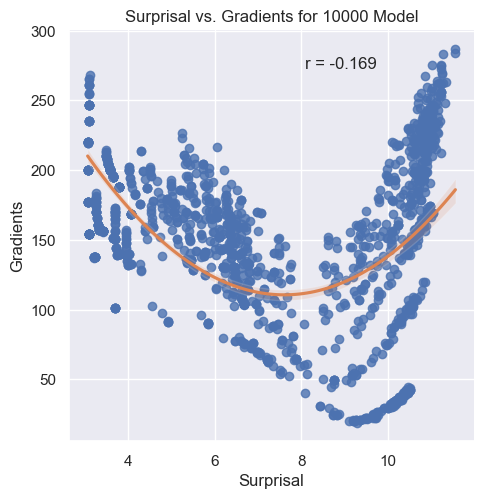

<Figure size 600x600 with 0 Axes>

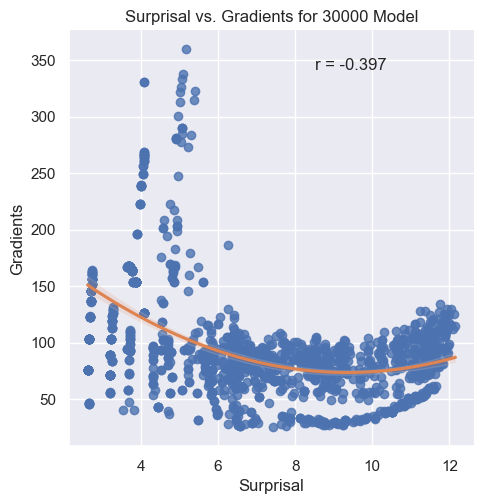

<Figure size 600x600 with 0 Axes>

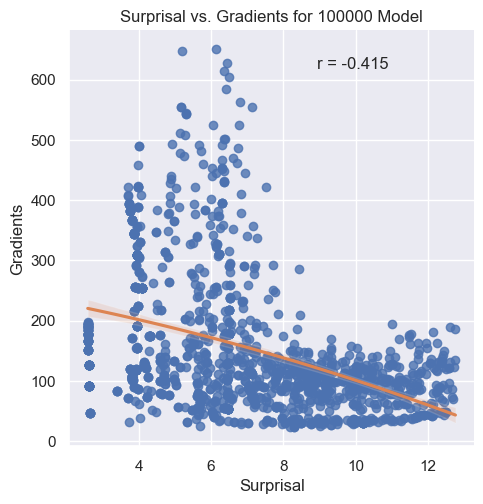

<Figure size 600x600 with 0 Axes>

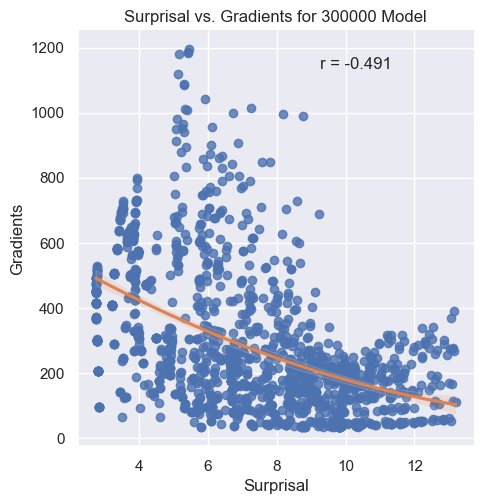

<Figure size 600x600 with 0 Axes>

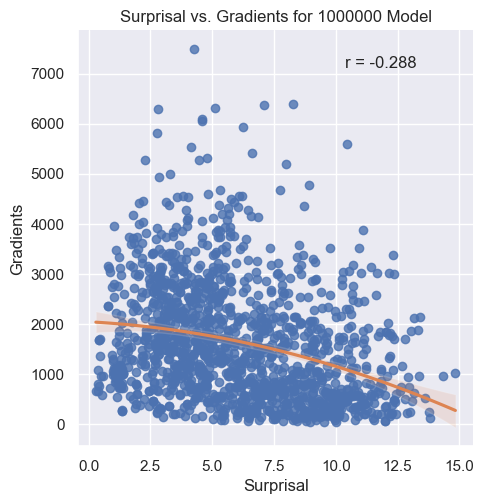

<Figure size 600x600 with 0 Axes>

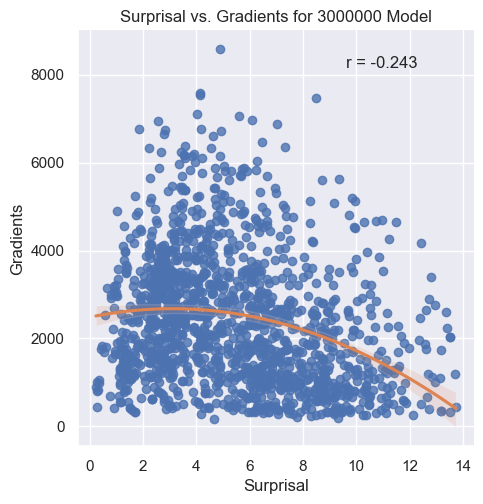

<Figure size 600x600 with 0 Axes>

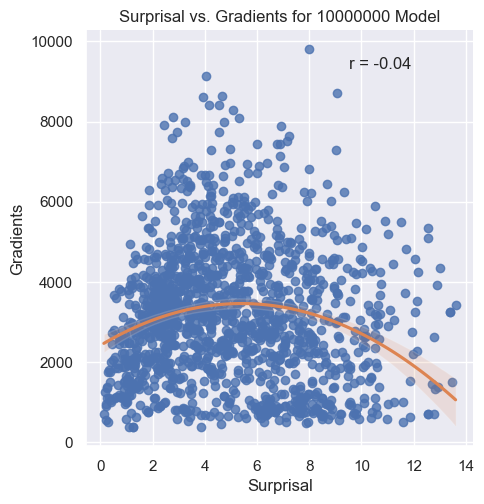

<Figure size 600x600 with 0 Axes>

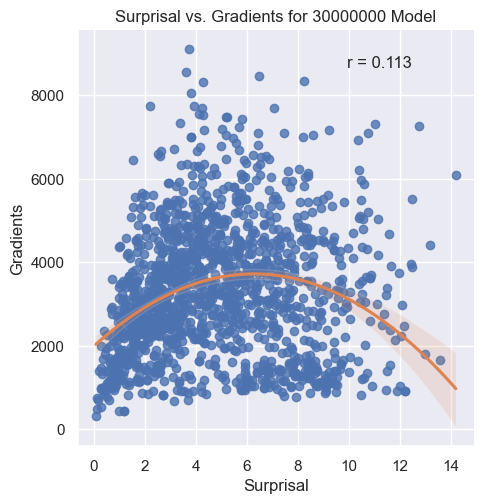

<Figure size 600x600 with 0 Axes>

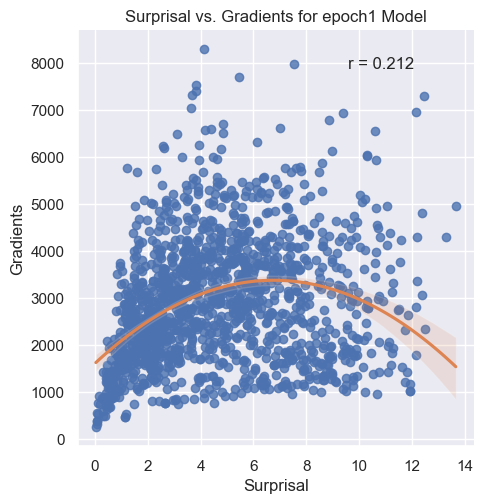

In [225]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = model_stimuli_df.columns.str.contains("surp_*")
surpisal_columns_df = model_stimuli_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_df.columns:
    model_size_string = column_name[5:]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}", 
        y_axis_name=f"grad_{model_size_string}", 
        df=model_stimuli_df,
        x_axis_label="Surprisal",
        y_axis_label="Gradients",
        title=f"Surprisal vs. Gradients for {model_size_string} Model"
    )
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,-0.169280
1,30000,-0.397402
2,100000,-0.415221
3,300000,-0.491036
4,1000000,-0.287649
5,3000000,-0.243196
6,10000000,-0.040046
7,30000000,0.113212
8,epoch1,0.212030


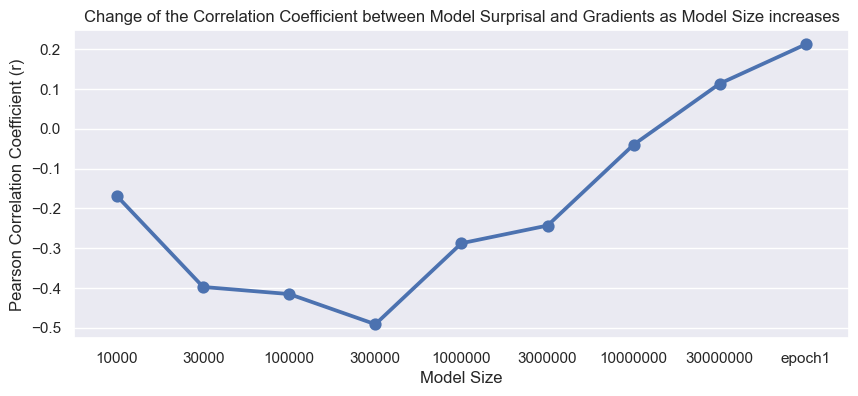

In [226]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
plt.title("Change of the Correlation Coefficient between Model Surprisal and Gradients as Model Size increases")
regression_data_df

### Visualizing Correlations between P600 Components and Model Surprisal
We draw plots of a model's surprisal values versus the mean P600 Component for every model size, then draw a final plot to show the change in Pearson Correlation Coefficient between the two variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

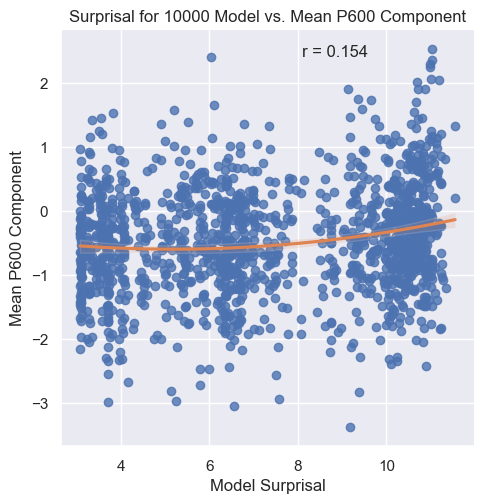

<Figure size 600x600 with 0 Axes>

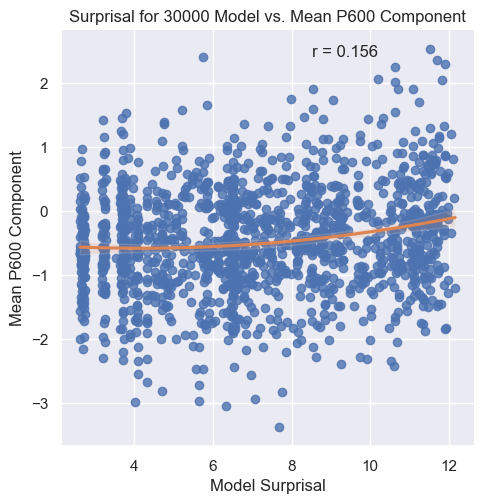

<Figure size 600x600 with 0 Axes>

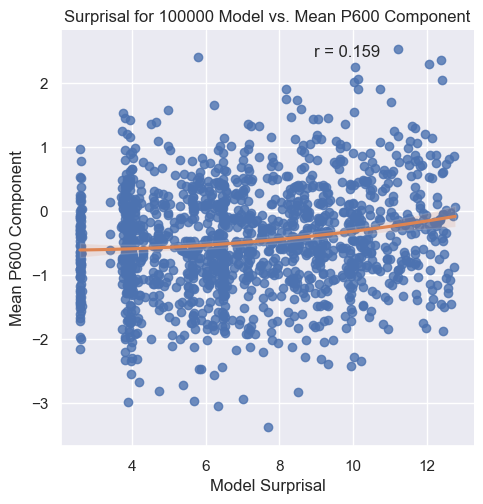

<Figure size 600x600 with 0 Axes>

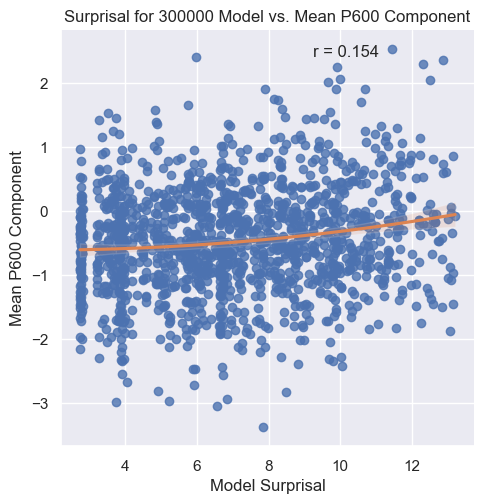

<Figure size 600x600 with 0 Axes>

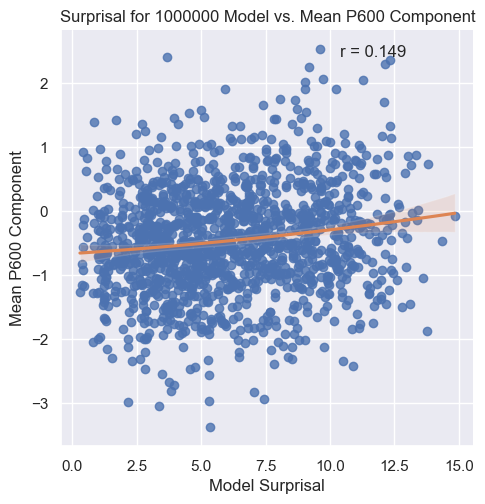

<Figure size 600x600 with 0 Axes>

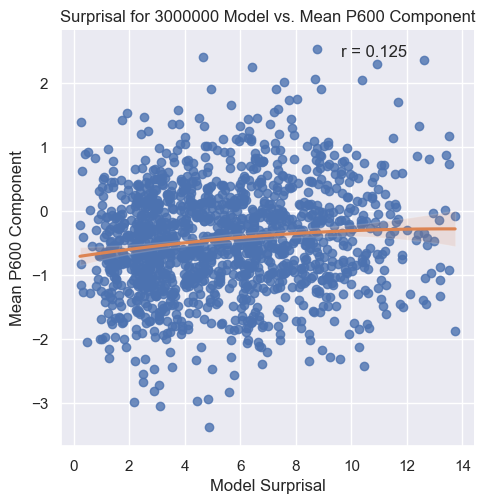

<Figure size 600x600 with 0 Axes>

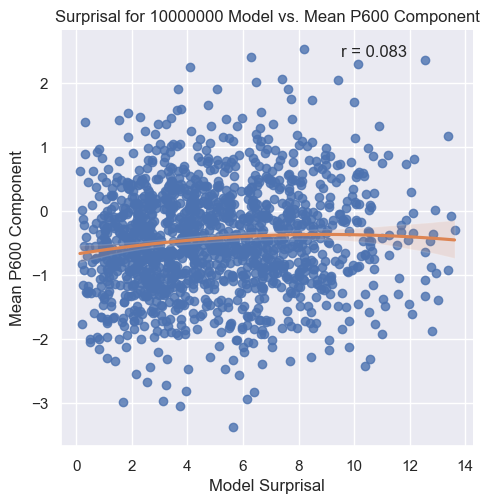

<Figure size 600x600 with 0 Axes>

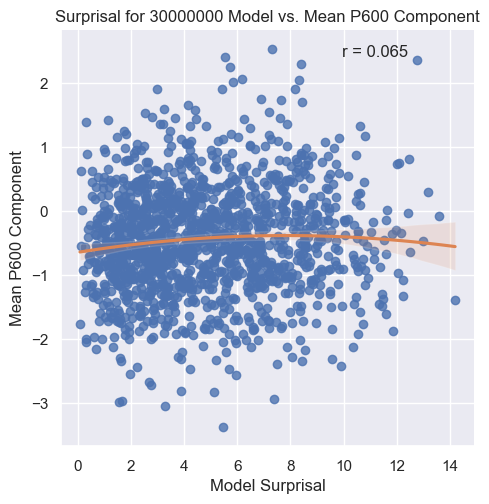

<Figure size 600x600 with 0 Axes>

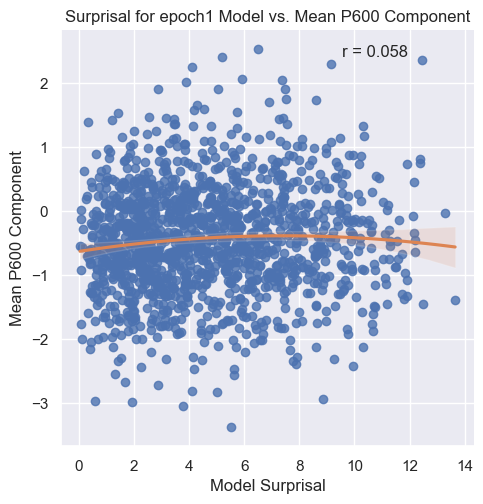

In [227]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = model_stimuli_df.columns.str.contains("surp_*")
surpisal_columns_df = model_stimuli_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_df.columns:
    model_size_string = column_name[5:]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}", 
        y_axis_name="erp_p600_mean", 
        df=model_stimuli_df,
        x_axis_label="Model Surprisal",
        y_axis_label="Mean P600 Component",
        title=f"Surprisal for {model_size_string} Model vs. Mean P600 Component"
    )
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.154006
1,30000,0.156128
2,100000,0.158718
3,300000,0.154243
4,1000000,0.149008
5,3000000,0.125367
6,10000000,0.082929
7,30000000,0.065154
8,epoch1,0.058046


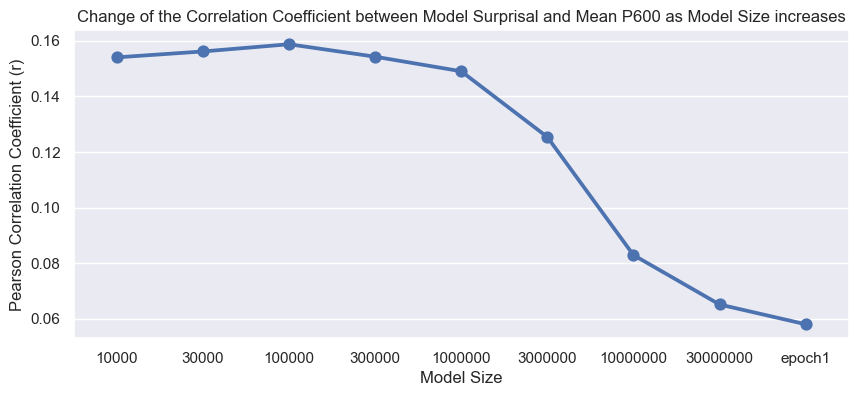

In [228]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
plt.title("Change of the Correlation Coefficient between Model Surprisal and Mean P600 as Model Size increases")
regression_data_df

### Visualizing Correlations between P600 Components and Model Gradients
We draw plots of a model's gradient values versus the mean P600 Component for every model size, then draw a final plot to show the change in Pearson Correlation Coefficient between the two variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

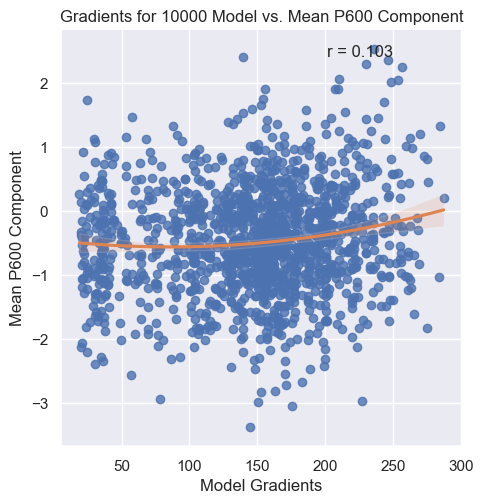

<Figure size 600x600 with 0 Axes>

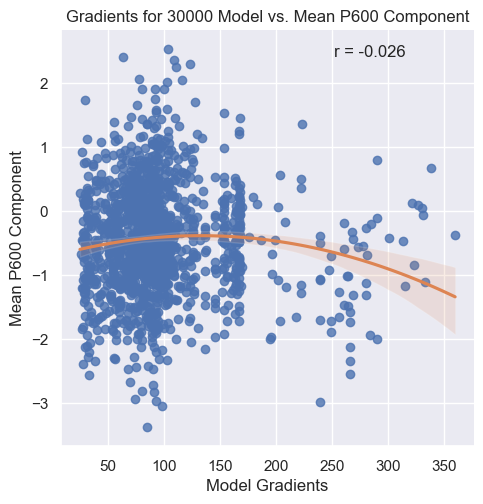

<Figure size 600x600 with 0 Axes>

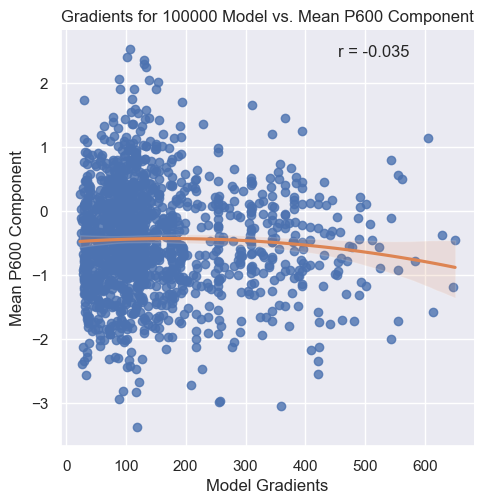

<Figure size 600x600 with 0 Axes>

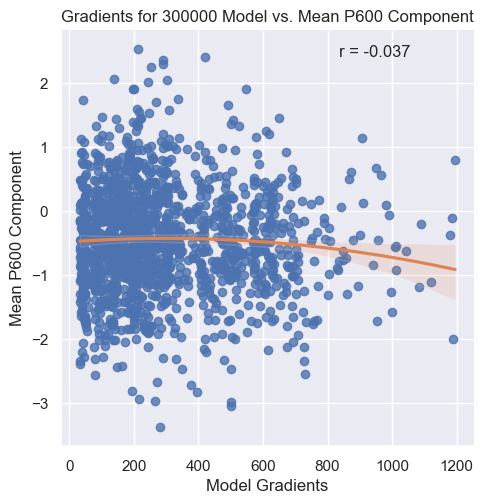

<Figure size 600x600 with 0 Axes>

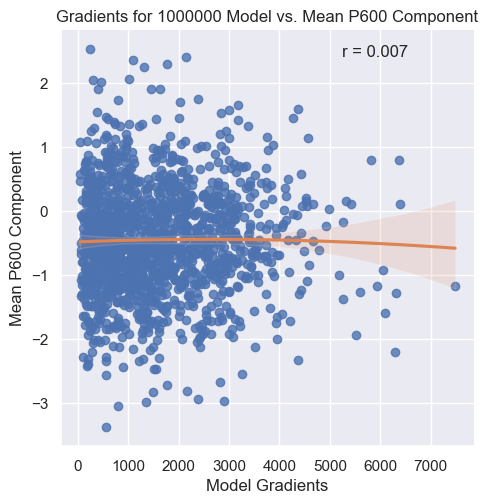

<Figure size 600x600 with 0 Axes>

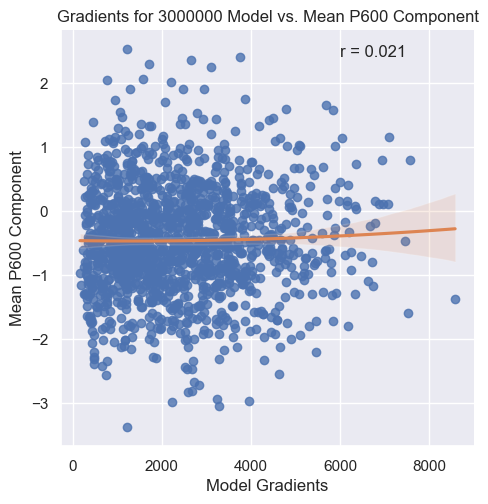

<Figure size 600x600 with 0 Axes>

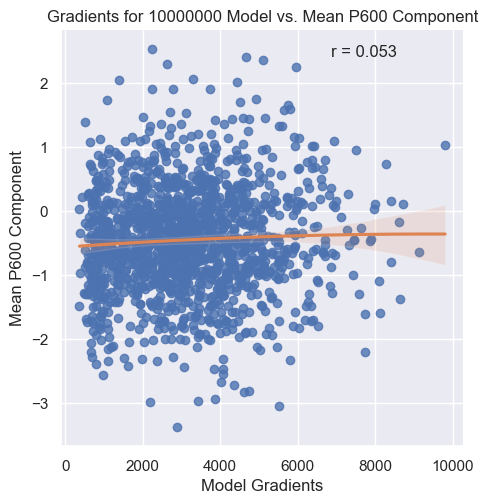

<Figure size 600x600 with 0 Axes>

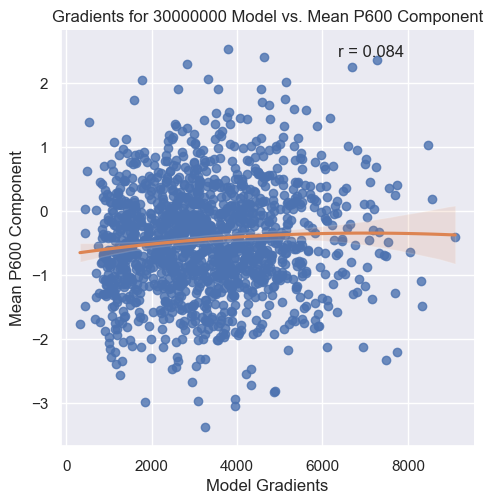

<Figure size 600x600 with 0 Axes>

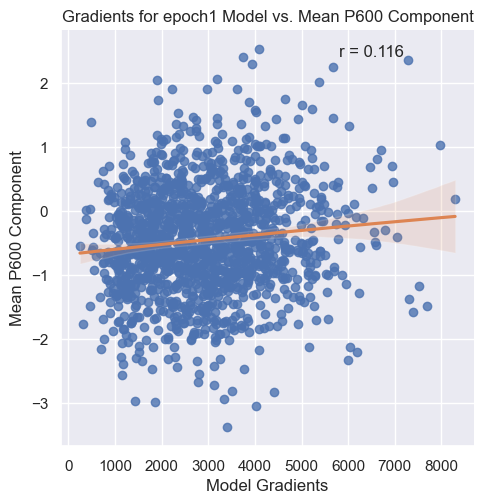

In [229]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = model_stimuli_df.columns.str.contains("grad_*")
gradient_columns_df = model_stimuli_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_df.columns:
    model_size_string = column_name[5:]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"grad_{model_size_string}", 
        y_axis_name="erp_p600_mean", 
        df=model_stimuli_df,
        x_axis_label="Model Gradients",
        y_axis_label="Mean P600 Component",
        title=f"Gradients for {model_size_string} Model vs. Mean P600 Component"
    )
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.102966
1,30000,-0.025943
2,100000,-0.035172
3,300000,-0.037326
4,1000000,0.006671
5,3000000,0.021146
6,10000000,0.052913
7,30000000,0.083867
8,epoch1,0.115635


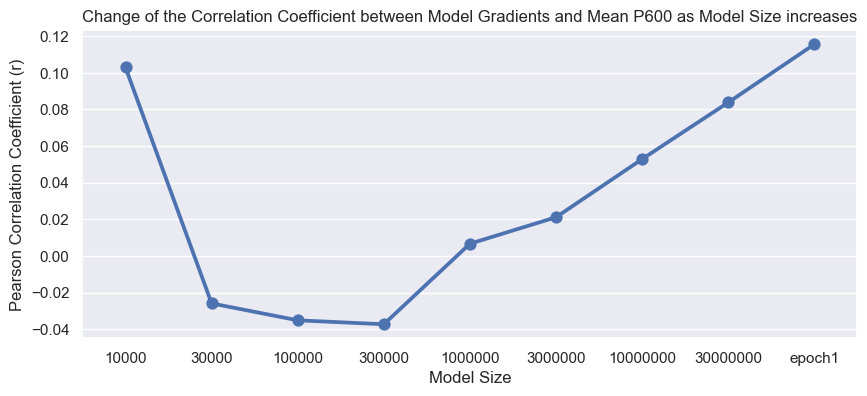

In [230]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
plt.title("Change of the Correlation Coefficient between Model Gradients and Mean P600 as Model Size increases")
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
regression_data_df